In [8]:
#This script creates visualizations of empirical coverage and confidence region area for 95 percent approximate confidence regions for exact likelihoood,
#neural likelihood, and uncalibrated neural likelihood.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry import Polygon as geometry_polygon
from mpl_toolkits.axes_grid1 import ImageGrid

In [9]:
#Load exact likelihood surfaces and neural likelihood surfaces (both uncalibrated and calibrated)
image_size = 25
image_name = str(image_size) + "_by_" + str(image_size)
local_folder = "/home/juliatest/Dropbox/likelihood_free_inference/neural_likelihood/gaussian_process"
exact_likelihood_surfaces_file = (local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                                  "/single/reps/200/evaluation_ll_fields_9_by_9_density_" 
               + image_name + "_200.npy")
exact_likelihood_surfaces = np.load(exact_likelihood_surfaces_file)

version = "final_version"
uncalibrated_neural_likelihood_surfaces_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + 
                                                image_name + "/" + version + "/uncalibrated/single/reps/200/"
                                        "/uncalibrated_neural_likelihood_surfaces_9_by_9_density_25_by_25_image_200.npy")
uncalibrated_neural_likelihood_surfaces = np.load(uncalibrated_neural_likelihood_surfaces_file)

calibrated_neural_likelihood_surfaces_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + 
                                              image_name + "/" + version + "/calibrated/single/reps/200/" +
                                              "calibrated_neural_likelihood_surfaces_9_by_9_density_25_by_25_image_200.npy")
calibrated_neural_likelihood_surfaces = np.load(calibrated_neural_likelihood_surfaces_file)

number_of_parameters = 81
number_of_reps = 200
#first column is variance and second is lengthscale
parameter_matrix = np.load((local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                            "/single/reps/200/evaluation_parameters_9_by_9_density_" + image_name + "_200.npy"))
parameter_matrix = parameter_matrix[:,0,:]
possible_lengthscales = [round(.05*i,2) for i in range(1, 41)]
possible_variances = [round(.05*i,2) for i in range(1, 41)]
#Cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
C = 5.99

In [42]:
#Compute the empirical coverage of the approximate confidence regions for exact likleihood
    #parameters:
        #exact_likelihood_surface: 40 by 40 matrix, exact log likelihood surface for a given realization of the GP
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #true_lengthscale: the lengthscale which generated the realization of the gp
        #true_variance: the variance which generated the realization of the gp
def compute_exact_likelihood_empirical_coverage(exact_likelihood_surface, possible_lengthscales, possible_variances, C, true_lengthscale, true_variance):

    max_field_value = np.max(exact_likelihood_surface)
    possible_lengthscales = np.array(possible_lengthscales)
    possible_variances = np.array(possible_variances)
    lengthscale_index = (np.where(possible_lengthscales == float(true_lengthscale)))[0]
    variance_index = (np.where(possible_variances == float(true_variance)))[0]
    true_field_value = (exact_likelihood_surface[variance_index, lengthscale_index])[0]
    difference = 2*(max_field_value - true_field_value)
    if(difference < 0):
        return "error"
    else:
        return (difference <= C)

#Compute the empirical coverage of the approximate confidence regions for neural likleihood (both calibrated and uncalibrated)
    #parameters:
        #neural_likelihood surface: 40 by 40 matrix, neural likelihood surface (calibrated or uncalibrated) for a given realization of the GP
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #true_lengthscale: the lengthscale which generated the realization of the gp
        #true_variance: the variance which generated the realization of the gp    
def compute_neural_likelihood_empirical_coverage(neural_likelihood_surface, possible_lengthscales, possible_variances, C, true_lengthscale, true_variance):

    max_field_value = np.log(np.max(neural_likelihood_surface))
    possible_lengthscales = np.array(possible_lengthscales)
    possible_variances = np.array(possible_variances)
    lengthscale_index = (np.where(possible_lengthscales == float(true_lengthscale)))[0]
    variance_index = (np.where(possible_variances == float(true_variance)))[0]
    true_field_value = np.log((neural_likelihood_surface[variance_index, lengthscale_index])[0])
    difference = 2*(max_field_value - true_field_value)
    if(difference < 0):
        return "error"
    else:
        return (difference <= C)

#Compute the area of the approximate confidence region
def compute_confidence_region_area(confidence_region):

    area = (geometry_polygon(zip(confidence_region[:,0], confidence_region[:,1]))).area
    return area

#compute the 9 by 9 grid over the parameter space which contains the empirical coverage
#in each cell corresponding to that parameter on the parameter grid for exact log likelihood
    #parameters:
        #exact_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the exact log likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of exact likelihood surfaces per parameter (200 each)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_empirical_coverage_matrix_for_exact_likelihood(exact_likelihood_surfaces, number_of_parameters, number_of_reps, 
                                                           possible_lengthscales, possible_variances, C, parameter_matrix):

    empirical_coverage_matrix = np.zeros((number_of_parameters, number_of_reps))
    empirical_coverage_visualization_matrix = np.zeros((9, 9))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_lengthscale = round(parameter_matrix[ipred, 0], 3)
            current_variance = round(parameter_matrix[ipred,1], 3)
            current_field = np.transpose(exact_likelihood_surfaces[ipred,irep,:,:])
            empirical_coverage_matrix[ipred,irep] = int(compute_exact_likelihood_empirical_coverage(current_field, possible_lengthscales, 
                                                                                                    possible_variances, C, current_lengthscale,
                                                                                                      current_variance))

        empirical_coverage_visualization_matrix[int(ipred / 9), int(ipred % 9)] = (np.sum(empirical_coverage_matrix[ipred,:])/number_of_reps)

    return empirical_coverage_visualization_matrix

#compute the 9 by 9 grid over the parameter space which contains the empirical coverage
#in each cell corresponding to that parameter on the parameter grid for neural likelihood (calibrated or uncalibrated)
    #parameters:
        #neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the neural likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of exact likelihood surfaces per parameter (200 each)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_empirical_coverage_matrix_for_neural_likelihood(neural_likelihood_surfaces, number_of_parameters, number_of_reps, possible_lengthscales,
                                                            possible_variances, C, parameter_matrix):

    empirical_coverage_matrix = np.zeros((number_of_parameters, number_of_reps))
    empirical_coverage_visualization_matrix = np.zeros((9, 9))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_lengthscale = round(parameter_matrix[ipred, 0], 3)
            current_variance = round(parameter_matrix[ipred,1], 3)
            current_field = neural_likelihood_surfaces[ipred,irep,:,:]
            empirical_coverage_matrix[ipred,irep] = int(compute_neural_likelihood_empirical_coverage(np.transpose(current_field), possible_lengthscales,
                                                                                                      possible_variances, C, current_lengthscale, 
                                                                                                      current_variance))

        empirical_coverage_visualization_matrix[int(ipred / 9), int(ipred % 9)] = (np.sum(empirical_coverage_matrix[ipred,:])/number_of_reps)

    return empirical_coverage_visualization_matrix

#Produce the approximate confidence region for a exact likelihood surface given a cut off value C
    #parameters:
        #exact_likelihood_surface: 40 by 40 matrix, exact log likelihood surface for a given realization of the GP
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
def produce_exact_likelihood_confidence_region(exact_likelihood_surface, possible_lengthscales, possible_variances, C):

    max_field_value = np.max(exact_likelihood_surface)
    field_difference = 2*(max_field_value - exact_likelihood_surface)
    confidence_grid = np.where(field_difference <= C, 1, 0)

    variance_values = []
    lengthscale_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[min_val])

    confidence_region = np.zeros((len(variance_values),2))
    confidence_region[:,0] = lengthscale_values
    confidence_region[:,1] = variance_values

    return confidence_region

#Produce the approximate confidence region for a neural likelihood surface (calibrated or uncalibrated) given a cut off value C
    #parameters:
        #neural_likelihood_surface: 40 by 40 matrix, neural likelihood surface for a given realization of the GP
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
def produce_neural_likelihood_confidence_region(neural_likelihood_surface, possible_lengthscales, possible_variances, C):

    max_field_value = np.log(np.max(neural_likelihood_surface))
    field_difference = 2*(max_field_value - np.log(neural_likelihood_surface))
    confidence_grid = np.where(field_difference <= C, 1, 0)

    variance_values = []
    lengthscale_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            #min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[min_val])

    confidence_region = np.zeros((len(variance_values),2))
    confidence_region[:,0] = lengthscale_values
    confidence_region[:,1] = variance_values

    return confidence_region

#compute the 9 by 9 grid over the parameter space which contains the approximate confidence region area
#in each cell corresponding to that parameter on the parameter grid for exact log likelihood
    #parameters:
        #exact_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the exact log likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of exact likelihood surfaces per parameter (200 each)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_exact_likelihood_confidence_region_area_matrix(exact_likelihood_surfaces, number_of_parameters, number_of_reps, 
                                                           possible_lengthscales, possible_variances, C, parameter_matrix):

    area_matrix = np.zeros((number_of_parameters, number_of_reps))
    area_visualization_matrix = np.zeros((9, 9))
    fig, ax = plt.subplots(figsize = (10,10))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_lengthscale = parameter_matrix[ipred,0]
            current_variance = parameter_matrix[ipred,1]
            current_field = exact_likelihood_surfaces[ipred,irep,:,:]
            confidence_region = produce_exact_likelihood_confidence_region(current_field, possible_lengthscales, possible_variances, C)
            if(confidence_region.shape[0] > 2):
                area_matrix[ipred,irep] = round(compute_confidence_region_area(confidence_region), 3)

        area_visualization_matrix[int(ipred / 9), int(ipred % 9)] = (np.sum(area_matrix[ipred,:])/number_of_reps)

    return area_visualization_matrix

#compute the 9 by 9 grid over the parameter space which contains the approximate confidence region area
#in each cell corresponding to that parameter on the parameter grid for neural likelihood (calibrated or uncalibrated)
    #parameters:
        #neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the neural likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of exact likelihood surfaces per parameter (200 each)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_neural_likelihood_confidence_region_area_matrix(neural_likelihood_surfaces, number_of_parameters, number_of_reps, possible_lengthscales,
                                                             possible_variances, C, parameter_matrix):

    area_matrix = np.zeros((number_of_parameters, number_of_reps))
    area_visualization_matrix = np.zeros((9, 9))
    fig, ax = plt.subplots(figsize = (10,10))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_field = neural_likelihood_surfaces[ipred,irep,:,:]
            confidence_region = produce_neural_likelihood_confidence_region(current_field, possible_lengthscales, possible_variances, C)
            if(confidence_region.shape[0] > 2):
                area_matrix[ipred,irep] = round(compute_confidence_region_area(confidence_region), 3)

        area_visualization_matrix[int(ipred / 9), int(ipred % 9)] = (np.sum(area_matrix[ipred,:])/number_of_reps)

    return area_visualization_matrix

#Function to visualize empirical coverages of exact likelihood, uncalibrated neural likelihood, and calibrated neural likelihood surfaces
#over the parameter space with a heat map
    #parameters:
        #exact_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the exact log likelihood surfaces for the evaluation data
        #uncalibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the uncalibrated neural likelihood surfaces
            #for the evaluation data
        #calibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the calibrated neural likelihood surfaces
            #for the evaluation data
            #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of exact likelihood surfaces per parameter (200 each)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def visualize_empirical_coverage(exact_likelihood_surfaces, uncalibrated_neural_likelihood_surfaces, calibrated_neural_likelihood_surfaces, 
                                 numberer_of_parameters, number_of_reps, possible_lengthscales, possible_variances, C, parameter_matrix):
    
    exact_likelihood_empirical_coverage_matrix = compute_empirical_coverage_matrix_for_exact_likelihood(exact_likelihood_surfaces, 
                                                                                                         numberer_of_parameters, number_of_reps,
                                                                                                         possible_lengthscales, possible_variances, 
                                                                                                         C, parameter_matrix)
    uncalibrated_neural_likelihood_empirical_coverage_matrix = compute_empirical_coverage_matrix_for_neural_likelihood(uncalibrated_neural_likelihood_surfaces, 
                                                                                                                       numberer_of_parameters, number_of_reps, 
                                                                                                                       possible_lengthscales, possible_variances,
                                                                                                                       C, parameter_matrix)
    calibrated_neural_likelihood_empirical_coverage_matrix = compute_empirical_coverage_matrix_for_neural_likelihood(calibrated_neural_likelihood_surfaces, 
                                                                                                                     numberer_of_parameters, number_of_reps,
                                                                                                                     possible_lengthscales, possible_variances,
                                                                                                                     C, parameter_matrix)

    fig = plt.figure(figsize=(20, 7.2))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,3),
                    axes_pad=0.55,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.3,
                    label_mode = "all"
                    )

    empirical_coverage_matrices = [exact_likelihood_empirical_coverage_matrix, uncalibrated_neural_likelihood_empirical_coverage_matrix,
                                   calibrated_neural_likelihood_empirical_coverage_matrix]
    print(np.mean(exact_likelihood_empirical_coverage_matrix))
    print(np.mean(calibrated_neural_likelihood_empirical_coverage_matrix))
    titles = ["Exact Likelihood", "Neural (Uncalibrated)", "Neural (Calibrated)"]
    # Add data to image grid
    for i,ax in enumerate(grid):

        if(i == 0):
            ax.set_ylabel("variance", fontsize = 30)
        im = ax.imshow(empirical_coverage_matrices[i], interpolation='nearest', origin='lower', vmin = 0, vmax = 1, extent = [0,2,0,2])
        ax.set_xticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_yticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_title(titles[i], fontsize = 30)

    # Colorbar
    cbar = ax.cax.colorbar(im)
    cbar.set_label('Empirical Coverage', fontsize = 30, rotation = 90)
    ax.cax.toggle_label(True)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.5, 0.04, 'length scale', ha='center', va='center', fontsize = 30)
    #fig.text(0.1, 0.5, 'range', ha='center', va='center', rotation = 'vertical', fontsize = 40)
    plt.tight_layout()

    plt.tight_layout()
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_empirical_coverage_and_confidence_region_area/visualizations/empirical_coverage_visualization_200.png") 
    plt.savefig(fig_name)

#Function to visualize approximate confidence region area of exact likelihood, uncalibrated neural likelihood, and calibrated neural likelihood surfaces
#over the parameter space with a heat map
    #parameters:
        #exact_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the exact log likelihood surfaces for the evaluation data
        #uncalibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the uncalibrated neural likelihood surfaces
            #for the evaluation data
        #calibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the calibrated neural likelihood surfaces
            #for the evaluation data
            #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of exact likelihood surfaces per parameter (200 each)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def visualize_confidence_region_area(exact_likelihood_surfaces, uncalibrated_neural_likelihood_surfaces, calibrated_neural_likelihood_surfaces, 
                                 numberer_of_parameters, number_of_reps, possible_lengthscales, possible_variances, C, parameter_matrix):
  
    exact_likelihood_confidence_region_area_matrix = compute_exact_likelihood_confidence_region_area_matrix(exact_likelihood_surfaces, numberer_of_parameters,
                                                                                                            number_of_reps, possible_lengthscales, 
                                                                                                            possible_variances, C, parameter_matrix)
    uncalibrated_confidence_region_area_matrix = compute_neural_likelihood_confidence_region_area_matrix(uncalibrated_neural_likelihood_surfaces, 
                                                                                                         numberer_of_parameters, number_of_reps, 
                                                                                                         possible_lengthscales, possible_variances,
                                                                                                         C, parameter_matrix)
    calibrated_confidence_region_area_matrix = compute_neural_likelihood_confidence_region_area_matrix(calibrated_neural_likelihood_surfaces, 
                                                                                                       numberer_of_parameters, number_of_reps,
                                                                                                       possible_lengthscales, possible_variances, C, 
                                                                                                       parameter_matrix)
    

    fig = plt.figure(figsize=(20, 7.2))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,3),
                    axes_pad=0.55,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.3,
                    label_mode = "all"
                    )

    cr_matrices = [exact_likelihood_confidence_region_area_matrix, uncalibrated_confidence_region_area_matrix, calibrated_confidence_region_area_matrix]
    titles = ["Exact Likelihood", "Neural (Uncalibrated)", "Neural (Calibrated)"]
    # Add data to image grid
    for i,ax in enumerate(grid):
        if(i == 0):
            ax.set_ylabel("variance", fontsize = 30)
        im = ax.imshow(cr_matrices[i], interpolation='nearest', origin='lower', vmin = 0, vmax = .25, extent = [0,2,0,2])
        ax.set_xticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_yticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_title(titles[i], fontsize = 30)

    # Colorbar
    cbar = ax.cax.colorbar(im)
    cbar.set_label('Confidence Region Area', fontsize = 28, rotation = 90)
    ax.cax.toggle_label(True)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.5, 0.04, 'length scale', ha='center', va='center', fontsize = 30)

    plt.tight_layout()    
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_empirical_coverage_and_confidence_region_area/visualizations/confidence_region_area_visualization_200.png") 
    plt.savefig(fig_name)

0.9580246913580248
0.932530864197531


/tmp/ipykernel_147818/1359295034.py:299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_147818/1359295034.py:301: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


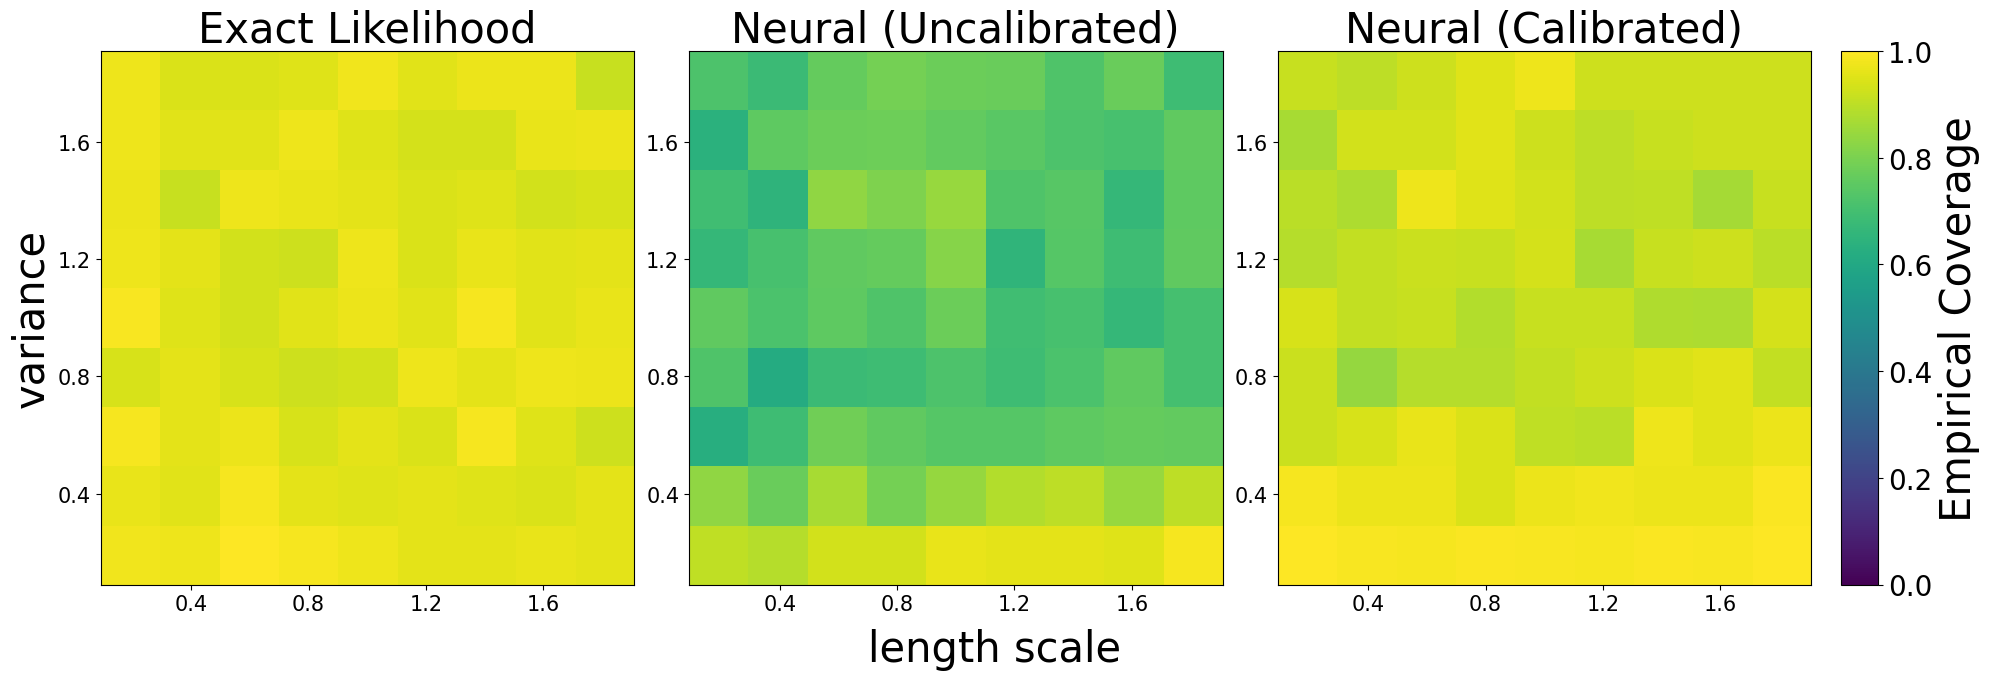

In [41]:
visualize_empirical_coverage(exact_likelihood_surfaces, uncalibrated_neural_likelihood_surfaces, calibrated_neural_likelihood_surfaces, 
                             number_of_parameters, number_of_reps, possible_lengthscales, possible_variances, C, parameter_matrix)

/tmp/ipykernel_147818/528523864.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


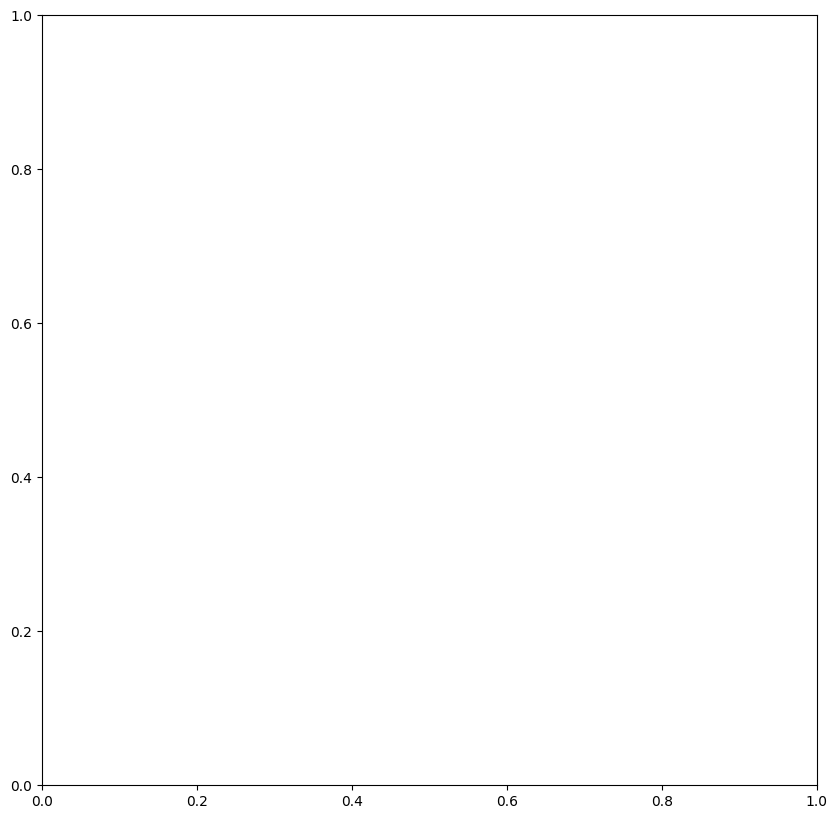

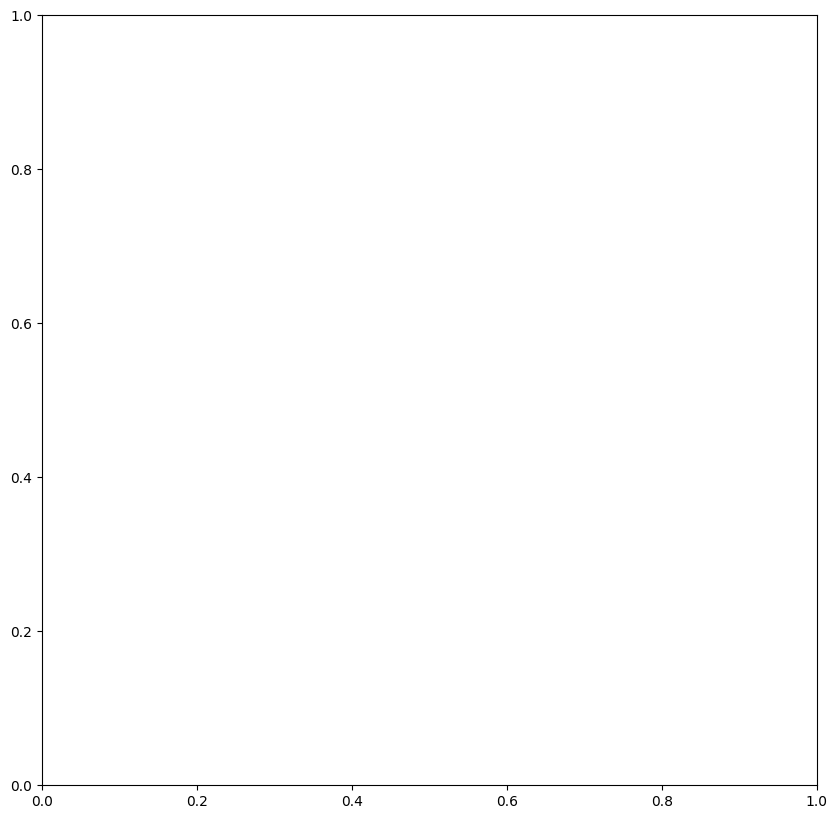

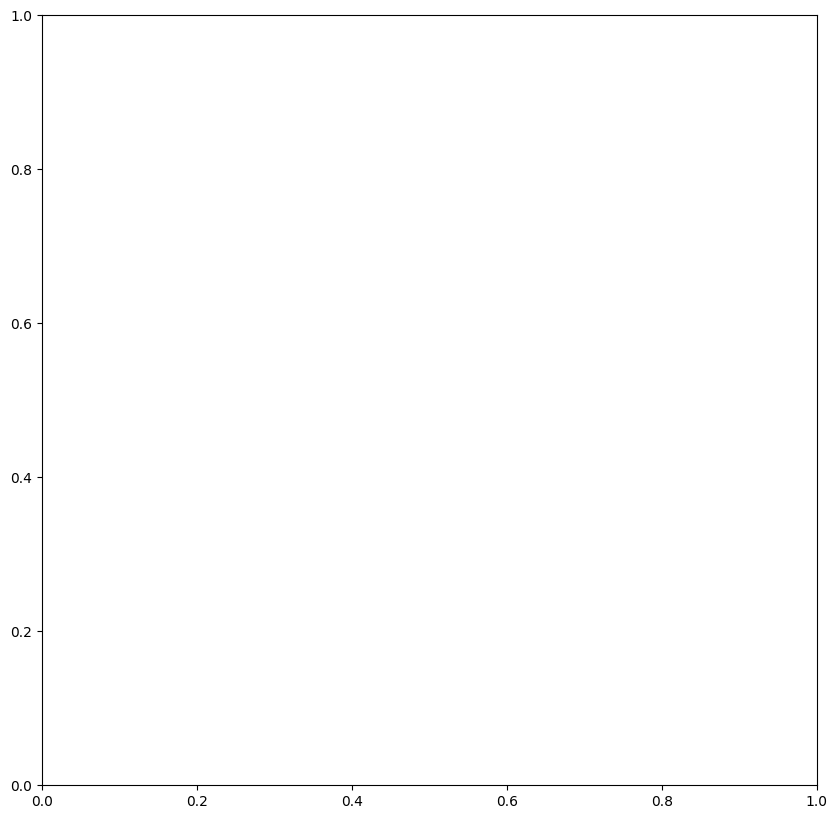

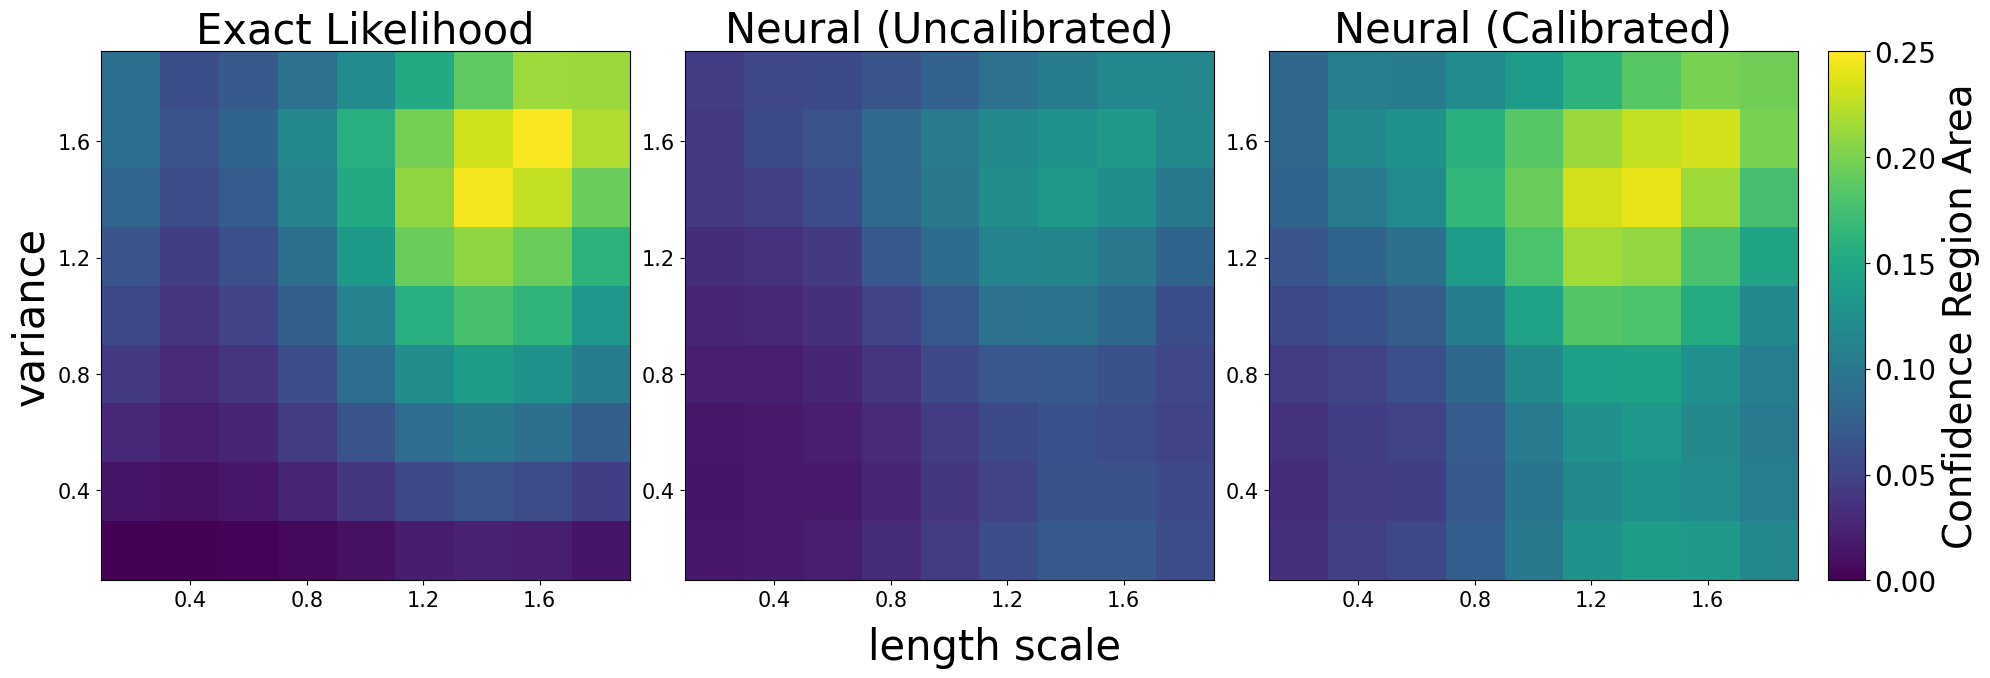

In [43]:
visualize_confidence_region_area(exact_likelihood_surfaces, uncalibrated_neural_likelihood_surfaces, calibrated_neural_likelihood_surfaces, 
                             number_of_parameters, number_of_reps, possible_lengthscales, possible_variances, C, parameter_matrix)